# Decision tree considering time window

In [16]:
import pandas as pd
import os
import numpy as np

# Arquivos CSV de queda e atividade normal
file_paths = {
    "QuedaFrente": "QuedaFrente.csv",
    "QuedaFrenteSentado": "QuedaFrenteSentado.csv",
    "QuedaLadoSentado": "QuedaLadoSentado.csv",
    "QuedaLateral": "QuedaLateral.csv",
    "QuedaTraz": "QuedaTraz.csv",
    "QuedaTrazSentado": "QuedaTrazSentado.csv",
    "QuedaTrazSentar": "QuedaTrazSentar.csv",
    "dbNoFall": "dbNoFall.csv"
}

# Lê todos os arquivos
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}


def process_falls(df, label=1, min_size=5):
    grouped = df.groupby('Teste')
    processed_rows = []

    for _, group in grouped:
        if len(group) < min_size:
            continue  # Ignorar quedas muito curtas
        group = group.drop(columns=['Time(ms)', 'Teste'], errors='ignore')
        flat_values = group.iloc[:min_size].to_numpy().flatten()  # Usar só os primeiros 5
        processed_rows.append(flat_values)

    if not processed_rows:
        return pd.DataFrame()  # Retornar vazio se nada válido

    base_columns = group.columns
    num_features = len(base_columns)
    max_len = max(len(row) for row in processed_rows)

    col_names = []
    for i in range(max_len // num_features):
        for col in base_columns:
            col_names.append(f"{col}{i+1}")

    df_processed = pd.DataFrame(processed_rows, columns=col_names)
    df_processed.insert(0, "isFall", label)
    return df_processed


def process_no_fall(df, group_size=5, label=0):
    df = df.drop(columns=['Time(ms)', 'Teste'], errors='ignore')
    processed_rows = []

    for i in range(0, len(df), group_size):
        group = df.iloc[i:i+group_size]
        if len(group) < group_size:
            continue
        flat_values = group.to_numpy().flatten()
        processed_rows.append(flat_values)

    if not processed_rows:
        return pd.DataFrame()

    base_columns = df.columns
    num_features = len(base_columns)
    max_len = max(len(row) for row in processed_rows)

    col_names = []
    for i in range(max_len // num_features):
        for col in base_columns:
            col_names.append(f"{col}{i+1}")

    df_processed = pd.DataFrame(processed_rows, columns=col_names)
    df_processed.insert(0, "isFall", label)
    return df_processed


# Processar quedas
falls_dfs = []
for name, df in dataframes.items():
    if name != "dbNoFall":
        processed_df = process_falls(df, label=1)
        if not processed_df.empty:
            falls_dfs.append(processed_df)

falls_final_df = pd.concat(falls_dfs, ignore_index=True)

# Processar atividade normal
no_fall_df = process_no_fall(dataframes["dbNoFall"], group_size=5, label=0)

# Combinar tudo
final_dataset = pd.concat([falls_final_df, no_fall_df], ignore_index=True)

# Limpar valores inválidos
final_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
final_dataset.dropna(inplace=True)

# Salvar no CSV
final_dataset.to_csv("fall_dataset_final.csv", index=False)
print("✅ Arquivo 'fall_dataset_final.csv' gerado com sucesso.")


✅ Arquivo 'fall_dataset_final.csv' gerado com sucesso.


In [ ]:
from sklearn.utils import resample

# Separar as classes
df_fall = final_dataset[final_dataset['isFall'] == 1]
df_no_fall = final_dataset[final_dataset['isFall'] == 0]

# Quantidade da maior classe
max_size = len(df_no_fall)

# Aumentar a classe minoritária (queda) com reposição até igualar o tamanho da maior
df_fall_upsampled = resample(df_fall,
                             replace=True,        # amostragem com reposição
                             n_samples=max_size,  # igualar tamanho da classe maior
                             random_state=42)     # para reproducibilidade
from sklearn.utils import resample

# Separar as classes
df_fall = final_dataset[final_dataset['isFall'] == 1]
df_no_fall = final_dataset[final_dataset['isFall'] == 0]

# Quantidade da maior classe
max_size = len(df_no_fall)

# Aumentar a classe minoritária (queda) com reposição até igualar o tamanho da maior
df_fall_upsampled = resample(df_fall,
                             replace=True,        # amostragem com reposição
                             n_samples=max_size,  # igualar tamanho da classe maior
                             random_state=42)     # para reproducibilidade

# Juntar as duas classes balanceadas
df_balanced = pd.concat([df_no_fall, df_fall_upsampled])

# Embaralhar as linhas para misturar as classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Tamanho da classe queda (aumentada): {len(df_fall_upsampled)}")
print(f"Tamanho da classe não queda: {len(df_no_fall)}")
print(f"Tamanho total do dataset balanceado: {len(df_balanced)}")

# Salvar no CSV
df_balanced.to_csv("fall_dataset_balanced.csv", index=False)
print("✅ Arquivo 'fall_dataset_balanced.csv' gerado com sucesso.")
# Juntar as duas classes balanceadas
df_balanced = pd.concat([df_no_fall, df_fall_upsampled])

# Embaralhar as linhas para misturar as classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Tamanho da classe queda (aumentada): {len(df_fall_upsampled)}")
print(f"Tamanho da classe não queda: {len(df_no_fall)}")
print(f"Tamanho total do dataset balanceado: {len(df_balanced)}")

# Salvar no CSV
df_balanced.to_csv("fall_dataset_balanced.csv", index=False)
print("✅ Arquivo 'fall_dataset_balanced.csv' gerado com sucesso.")

Tamanho da classe queda (aumentada): 193
Tamanho da classe não queda: 193
Tamanho total do dataset balanceado: 386
✅ Arquivo 'fall_dataset_balanced.csv' gerado com sucesso.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, confusion_matrix

# Carregar os dados
df = pd.read_csv("fall_dataset_balanced.csv")  

# Separar variáveis e rótulo
X = df.drop(columns=["isFall"])
y = df["isFall"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Criar e treinar o modelo
clf = DecisionTreeClassifier(max_depth=5, random_state=42)  
clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = clf.predict(X_test)
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Exibir a árvore de decisão em texto
from sklearn.tree import export_text

tree_rules = export_text(clf, feature_names=list(X.columns))
print("\nÁrvore de Decisão (em texto):\n")
print(tree_rules)


Matriz de Confusão:
[[54  4]
 [ 2 56]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        58
           1       0.93      0.97      0.95        58

    accuracy                           0.95       116
   macro avg       0.95      0.95      0.95       116
weighted avg       0.95      0.95      0.95       116


Árvore de Decisão (em texto):

|--- GyrX(d/s)2 <= 3908.78
|   |--- GyrX(d/s)3 <= 3900.97
|   |   |--- AccZ(g)1 <= 15.73
|   |   |   |--- AccZ(g)2 <= 0.04
|   |   |   |   |--- class: 0
|   |   |   |--- AccZ(g)2 >  0.04
|   |   |   |   |--- class: 1
|   |   |--- AccZ(g)1 >  15.73
|   |   |   |--- ΔAccZ1 <= -26.00
|   |   |   |   |--- class: 1
|   |   |   |--- ΔAccZ1 >  -26.00
|   |   |   |   |--- class: 0
|   |--- GyrX(d/s)3 >  3900.97
|   |   |--- AccZ(g)2 <= 0.44
|   |   |   |--- AccX(g)1 <= 0.81
|   |   |   |   |--- GyrZ(d/s)3 <= 3.78
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- GyrZ(d/

# Decision tree considering min max and mean values

In [2]:
import pandas as pd
import os
import numpy as np

# Arquivos CSV
file_paths = {
    "QuedaFrente": "QuedaFrente.csv",
    "QuedaFrenteSentado": "QuedaFrenteSentado.csv",
    "QuedaLadoSentado": "QuedaLadoSentado.csv",
    "QuedaLateral": "QuedaLateral.csv",
    "QuedaTraz": "QuedaTraz.csv",
    "QuedaTrazSentado": "QuedaTrazSentado.csv",
    "QuedaTrazSentar": "QuedaTrazSentar.csv",
    "dbNoFall": "dbNoFall.csv"
}

# Lê os arquivos
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Função para processar quedas
def process_falls_stats(df, label=1, min_size=5):
    grouped = df.groupby('Teste')
    processed_rows = []

    for _, group in grouped:
        if len(group) < min_size:
            continue
        group = group.drop(columns=['Time(ms)', 'Teste'], errors='ignore')

        stats = {}
        for col in group.columns:
            stats[f"mean_{col}"] = group[col].mean()
            stats[f"min_{col}"] = group[col].min()
            stats[f"max_{col}"] = group[col].max()
        stats["isFall"] = label
        processed_rows.append(stats)

    return pd.DataFrame(processed_rows)

# Função para processar dados sem queda, agrupando de N em N
def process_no_fall_stats(df, group_size=10, label=0):
    df = df.drop(columns=['Time(ms)', 'Teste'], errors='ignore')
    processed_rows = []

    for i in range(0, len(df), group_size):
        group = df.iloc[i:i+group_size]
        if len(group) < group_size:
            continue

        stats = {}
        for col in group.columns:
            stats[f"mean_{col}"] = group[col].mean()
            stats[f"min_{col}"] = group[col].min()
            stats[f"max_{col}"] = group[col].max()
        stats["isFall"] = label
        processed_rows.append(stats)

    return pd.DataFrame(processed_rows)

# Processar quedas
falls_dfs = []
for name, df in dataframes.items():
    if name != "dbNoFall":
        processed_df = process_falls_stats(df, label=1)
        if not processed_df.empty:
            falls_dfs.append(processed_df)

falls_final_df = pd.concat(falls_dfs, ignore_index=True)

# Processar não-quedas
no_fall_df = process_no_fall_stats(dataframes["dbNoFall"], group_size=10, label=0)

# Juntar tudo
final_dataset = pd.concat([falls_final_df, no_fall_df], ignore_index=True)

# Limpar dados inválidos
final_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
final_dataset.dropna(inplace=True)


# Salvar resultado
final_dataset.to_csv("fall_dataset_stats.csv", index=False)
print("✅ Arquivo 'fall_dataset_stats.csv' gerado com sucesso.")


✅ Arquivo 'fall_dataset_stats.csv' gerado com sucesso.


Since we have less Fall data, we will use the oversampling strategy and increase this data before evaluating.

In [3]:
from sklearn.utils import resample

# Separar as classes
df_fall = final_dataset[final_dataset['isFall'] == 1]
df_no_fall = final_dataset[final_dataset['isFall'] == 0]

# Quantidade da maior classe
max_size = len(df_no_fall)

# Aumentar a classe minoritária (queda) com reposição até igualar o tamanho da maior
df_fall_upsampled = resample(df_fall,
                             replace=True,        # amostragem com reposição
                             n_samples=max_size,  # igualar tamanho da classe maior
                             random_state=42)     # para reproducibilidade

# Juntar as duas classes balanceadas
df_balanced = pd.concat([df_no_fall, df_fall_upsampled])

# Embaralhar as linhas para misturar as classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Tamanho da classe queda (aumentada): {len(df_fall_upsampled)}")
print(f"Tamanho da classe não queda: {len(df_no_fall)}")
print(f"Tamanho total do dataset balanceado: {len(df_balanced)}")

# Salvar no CSV
df_balanced.to_csv("fall_db_stats_balanced.csv", index=False)
print("✅ Arquivo 'fall_db_stats_balanced.csv' gerado com sucesso.")

Tamanho da classe queda (aumentada): 96
Tamanho da classe não queda: 96
Tamanho total do dataset balanceado: 192
✅ Arquivo 'fall_db_stats_balanced.csv' gerado com sucesso.


-> Matriz de Confusão:
[[29  0]
 [ 0 29]]

🔹 Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        29

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58


-> Árvore de Decisão (em texto):

|--- min_ΔAccX <= -61.50
|   |--- max_GyrY(d/s) <= 3978.05
|   |   |--- class: 0
|   |--- max_GyrY(d/s) >  3978.05
|   |   |--- min_ΔAccY <= -45.50
|   |   |   |--- class: 1
|   |   |--- min_ΔAccY >  -45.50
|   |   |   |--- class: 0
|--- min_ΔAccX >  -61.50
|   |--- min_ΔAccY <= -137.00
|   |   |--- mean_ΔGyrY <= 4139.88
|   |   |   |--- class: 1
|   |   |--- mean_ΔGyrY >  4139.88
|   |   |   |--- class: 0
|   |--- min_ΔAccY >  -137.00
|   |   |--- class: 0



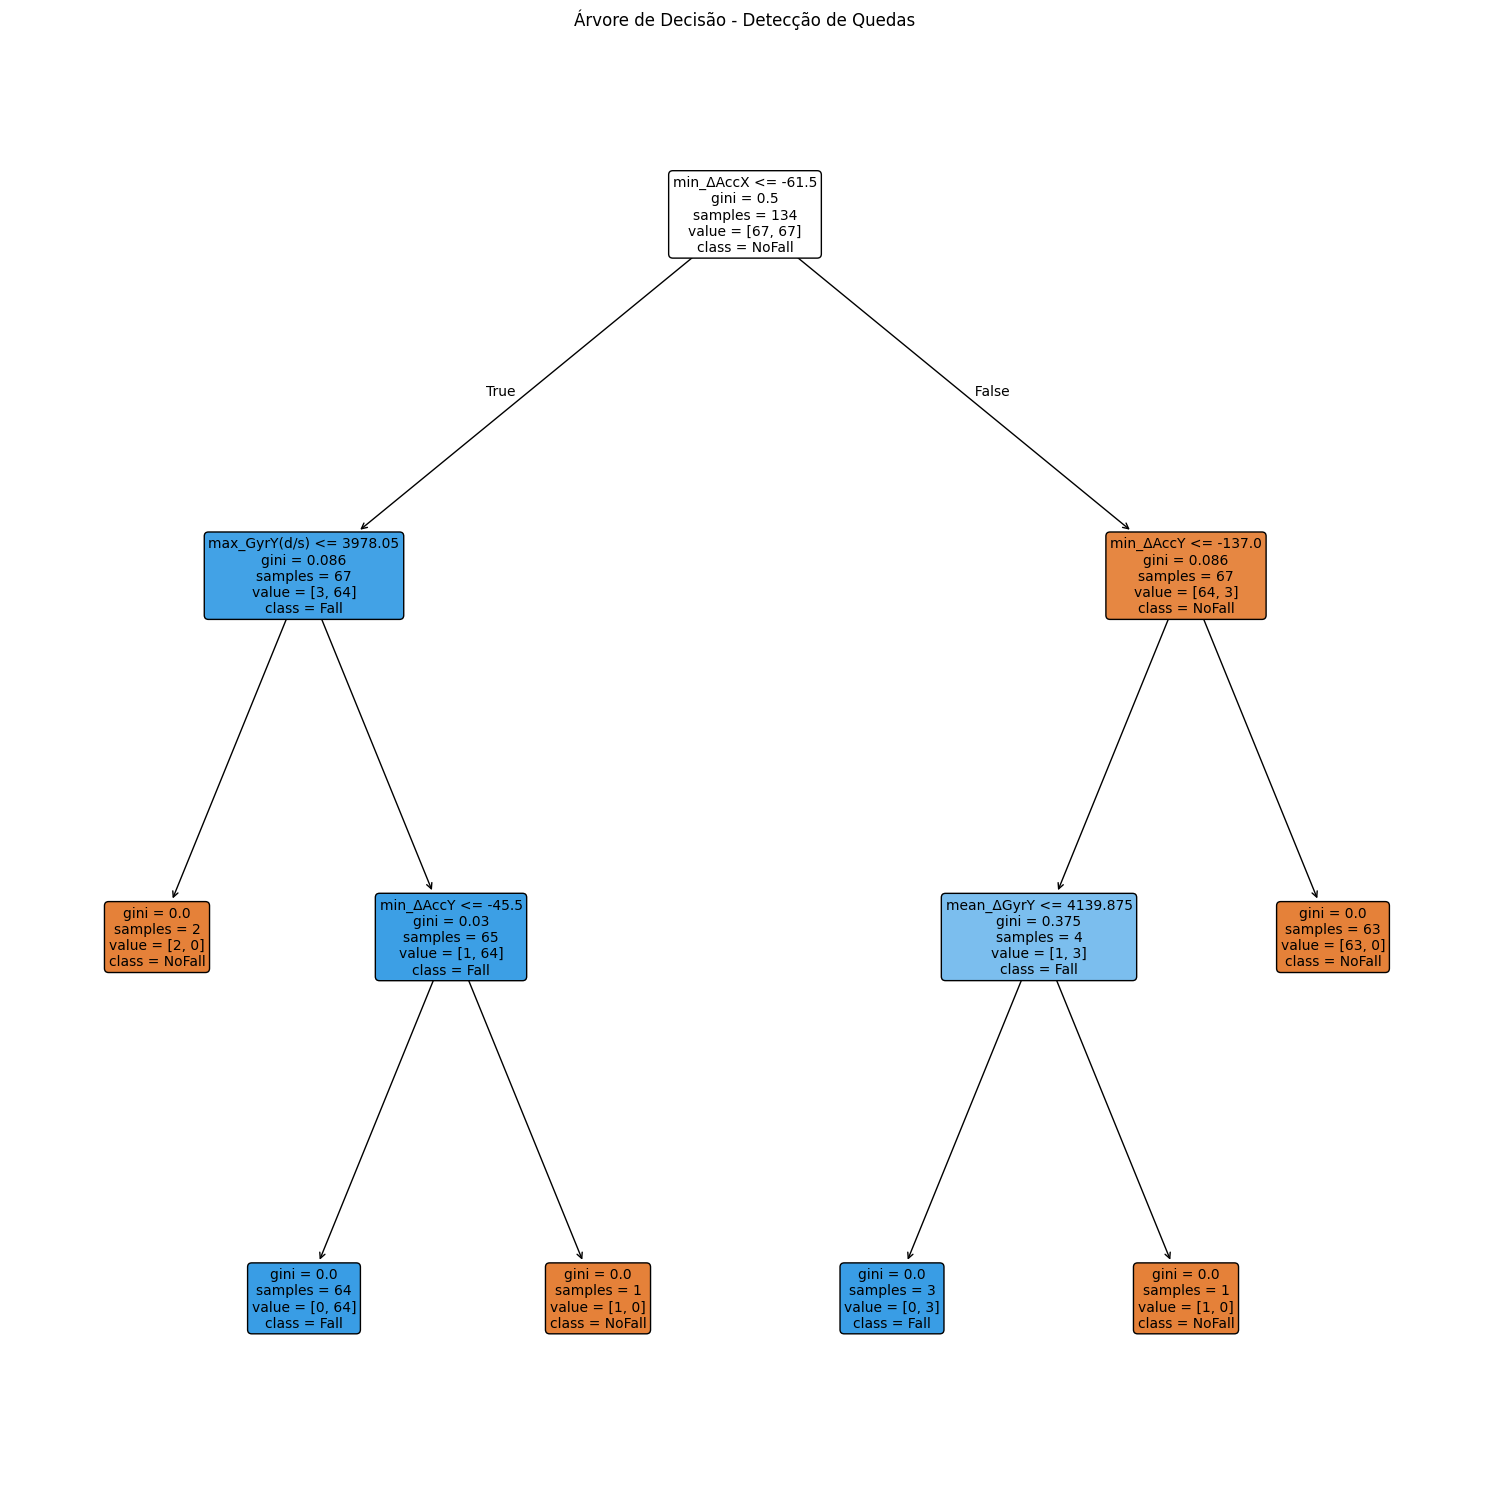

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

# Carregar os dados
df = pd.read_csv("fall_db_stats_balanced.csv")  # Substitua com seu caminho

# Separar variáveis (X) e rótulo (y)
X = df.drop(columns=["isFall"])
y = df["isFall"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Criar e treinar a árvore de decisão
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = clf.predict(X_test)
print("-> Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\n🔹 Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Exibir a árvore de decisão em texto (sem truncar)
print("\n-> Árvore de Decisão (em texto):\n")
tree_rules = export_text(clf, feature_names=list(X.columns))  
print(tree_rules)

# Desenhar a árvore de decisão
plt.figure(figsize=(15, 15)) 
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["NoFall", "Fall"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Árvore de Decisão - Detecção de Quedas")
plt.tight_layout()
plt.show()

